# Plot AEW tracks during campaign

Plot climatological AEW tracks, actual tracks, and Meteor ship track, between August 16 and September 24, through 4S-20N,20W to 60W [or August 10-September 30 for whole campaign]

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime, timedelta
import pandas as pd
import cftime
import geopy.distance
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sn
import cartopy

In [10]:
# Define constants
years = np.arange(1979, 2024)  # Year range for climatology 1979 to 2023 inclusive
#lat1, lat2 = -2, 22.1             # Latitude range
#lon1, lon2 = -62.1, -9.9            # Longitude range
lat1, lat2 = -0.1, 20.1             # Latitude range
lon1, lon2 = -60.1, -19.9            # Longitude range
gridsize = 1                     # Grid size for track density
mon1 = 8
day1 = 16
mon2 = 9
day2 = 24

Ship data

In [3]:
# Load ship track data from a NetCDF file using xarray
ds = xr.open_dataset('/Users/awing/Dropbox/ORCESTRA/data/meteor_meteo_dship_20240923.nc')

# Extract variables directly from xarray dataset
shipLON = ds['lon'].values
shipLAT = ds['lat'].values
shipTIME = ds['time'].values

ds.close()

AEW Climatology

In [4]:
#Load historical AEW tracks to generate a climatology

#Load one file to get lat/lon arrays
ds = xr.open_dataset('/Users/awing/Dropbox/AEWtracks/ERA5_AEW_TRACKS/AEW_tracks_post_processed_year_1986.nc')
lat = ds['latitude'].values
lon = ds['longitude'].values  
ds.close()

In [11]:
AEWcount = np.zeros(len(years))  # Count of AEWs per year
AEWlon_subset = np.full((81, 612, len(years)), np.nan)  # Initialize as NaN arrays
AEWlat_subset = np.full((81, 612, len(years)), np.nan)
start_date = cftime.DatetimeGregorian(1900, 1, 1, 0, 0, 0)  # Use cftime for high capacity date handling

# Loop over each year
for i, year in enumerate(years):
    # Define file path (adjust with actual file path structure)
    fname = f'/Users/awing/Dropbox/AEWtracks/ERA5_AEW_TRACKS/AEW_tracks_post_processed_year_{year}.nc'

    # Open the NetCDF file for the current year
    with xr.open_dataset(fname, decode_times=False) as ds:
        # Load latitude, longitude, and time data
        AEW_lon = ds['AEW_lon_smooth'].values  # Time x System
        AEW_lat = ds['AEW_lat_smooth'].values
        time = ds['time'].values  # Time in hours since 1900-01-01 00:00:00.0

        # Get dimensions
        nsystem, ntime = AEW_lat.shape

        # Convert time to datetime using cftime
        dates = [start_date + pd.Timedelta(hours=int(t)) for t in time]
        month_day = [(d.month, d.day) for d in dates]  # Extract month and day

        # Filter indices within the specified date range
        itimecheck = [k for k, (m, d) in enumerate(month_day)
                      if (m == mon1 and d >= day1) or (m == mon2 and d <= day2)]

        # Subset the AEW latitude and longitude data
        AEWlon = AEW_lon[:,itimecheck]
        AEWlat = AEW_lat[:,itimecheck]
        AEWlon_subset[:nsystem, itimecheck, i] = AEWlon
        AEWlat_subset[:nsystem, itimecheck, i] = AEWlat

        # Loop over each system to check if it falls within the region
        for j in range(nsystem):
            # Identify points within the specified region
            iregioncheck = np.where((AEWlat[j, :] >= lat1) & (AEWlat[j, :] <= lat2) &
                                    (AEWlon[j, :] >= lon1) & (AEWlon[j, :] <= lon2))[0]

            # Increment count if any points are within the region
            if iregioncheck.size > 0:
                AEWcount[i] += 1

# Print the AEW count per year for verification
print("AEW count per year:", AEWcount)

#Climatological average AEWcount for that time period/region (average AEWcount over all years)
climoAEWcount = np.mean(AEWcount)
print("climoAEWcount:", climoAEWcount)

ds.close()

AEW count per year: [12. 13. 17. 16. 16. 13. 14. 11. 14. 15. 16. 12. 14. 16. 18. 11. 14. 14.
 12. 12. 14. 16. 14. 14. 12. 15. 14. 16. 12. 13. 13. 11. 12. 12. 14. 18.
 13. 12. 13. 11. 13. 18. 15. 15. 14.]
climoAEWcount: 13.866666666666667


In [12]:
#Track density calculation
# grid
Xp = np.arange(lon1, lon2+1, gridsize)  # Longitude grid
Yp = np.arange(lat2, lat1-1, -gridsize)      # Latitude grid in reverse order
lx = len(Xp)
ly = len(Yp)

# Initialize track density array
trden = np.zeros((ly, lx, len(years)))

# Loop over all years, all storms, all points along tracks
for i in range(81):  # systems
    for j in range(612):  # track points
        for k in range(len(years)):  # years
            # If the storm can be assigned to 2 grid boxes, choose the nearest one
            ix = np.where((Xp >= AEWlon_subset[i, j, k] - gridsize / 2) &
                          (Xp < AEWlon_subset[i, j, k] + gridsize / 2))[0]
            if len(ix) > 1:
                diff = Xp[ix] - AEWlon_subset[i, j, k]
                ixv = ix[np.argmin(np.abs(diff))]
            else:
                ixv = ix[0] if ix.size > 0 else None

            iy = np.where((Yp >= AEWlat_subset[i, j, k] - gridsize / 2) &
                          (Yp < AEWlat_subset[i, j, k] + gridsize / 2))[0]
            if len(iy) > 1:
                diff = Yp[iy] - AEWlat_subset[i, j, k]
                iyv = iy[np.argmin(np.abs(diff))]
            else:
                iyv = iy[0] if iy.size > 0 else None

            # Update the track density if ixv and iyv are valid
            if ixv is not None and iyv is not None:
                trden[iyv, ixv, k] += 0.25  # Because tracks given four times per day


# Calculate the average track density over all years
trden_avg = np.mean(trden, axis=2)

# Make the average track density NaN where it is zero
trden_avg = np.where(trden_avg == 0, np.nan, trden_avg)

AEW tracks during BOWTIE

In [13]:
#Open the file with the AEW tracks from August-September 2024
ds = xr.open_dataset('/Users/awing/Dropbox/ORCESTRA/code/AEWtracking/AEW_tracks_BOWTIE_post_processed.nc',decode_times=False)

AEW_lon2024 = ds['AEW_lon_smooth'].values  # Time x System
AEW_lat2024 = ds['AEW_lat_smooth'].values
time2024 = ds['time'].values  # Time in seconds since 1970-01-01 00:00:00.0
start_date2024 = cftime.DatetimeGregorian(1970, 1, 1, 0, 0, 0)  # Use cftime for high capacity date handling

# Get dimensions
nsystem2024, ntime2024 = AEW_lat2024.shape

AEWcount2024 = 0  # Iniitialize Count of AEWs in 2024

# Convert time to datetime using cftime
dates2024 = [start_date2024 + pd.Timedelta(seconds=int(t)) for t in time2024]
month_day2024 = [(d.month, d.day) for d in dates2024]  # Extract month and day

# Filter indices within the specified date range (August 16 - September 24)
itimecheck2024 = [k for k, (m, d) in enumerate(month_day2024)
               if (m == mon1 and d >= day1) or (m == mon2 and d <= day2)]

# Subset the AEW latitude and longitude data
AEWlon2024 = AEW_lon2024[:,itimecheck2024]
AEWlat2024 = AEW_lat2024[:,itimecheck2024]

# Loop over each system to check if it falls within the region
for j in range(nsystem2024):
            # Identify points within the specified region
            iregioncheck = np.where((AEWlat2024[j, :] >= lat1) & (AEWlat2024[j, :] <= lat2) &
                                    (AEWlon2024[j, :] >= lon1) & (AEWlon2024[j, :] <= lon2))[0]

            # Increment count if any points are within the region
            if iregioncheck.size > 0:
                AEWcount2024 += 1

print("AEW count in 2024:", AEWcount2024)

AEW count in 2024: 13


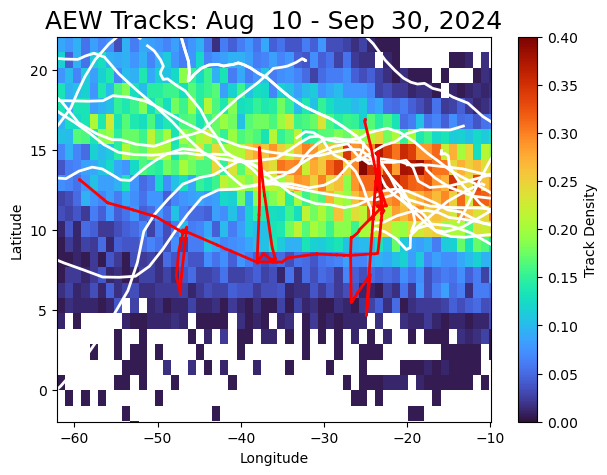

In [11]:
#Plot the ship track and track density
# Create a figure
fig, ax = plt.subplots(figsize=(7, 5))

#plot the track density
cax = ax.imshow(trden_avg, extent=(Xp[0], Xp[-1], Yp[0], Yp[-1]), aspect='auto', cmap='turbo', origin='lower', vmin=0, vmax=0.4)

#plot the AEW tracks in 2024
nAEW2024, ntimeAEW2024 = AEWlat2024.shape
for i in range(nAEW2024):
    ax.plot(AEWlon2024[i, :], AEWlat2024[i, :], 'w', linewidth=2)

#plot the ship track
ax.plot(shipLON, shipLAT, 'r', linewidth=2)

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label('Track Density')

# Set the axis limits
ax.set_xlim(lon1, lon2)
ax.set_ylim(lat2, lat1)

# Set the y-axis direction to normal (increasing upwards)
ax.invert_yaxis()

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'AEW Tracks: Aug  {day1:2.0f} - Sep  {day2:2.0f}, 2024', fontsize=18)     


# Show the plot
plt.show()


In [14]:
# Add ERA-5 mean CWV
era5 = xr.open_dataset('/Users/awing/Dropbox/ORCESTRA/data/ERA5_hrly_OLR_Prec_PW_20240809.nc')

# average ERA-5 CWV over time period of campaign
start_time = np.datetime64('2024-08-16T00:00:00')
index_start = np.where(pd.to_datetime(era5.valid_time) == start_time)[0]
index_start = int(index_start[0])

end_time = np.datetime64('2024-09-24T00:00:00')
index_end = np.where(pd.to_datetime(era5.valid_time) == end_time)[0]
index_end = int(index_end[0])

tcwv_mean = era5.tcwv[index_start:index_end].mean(dim='valid_time')

/opt/anaconda3/envs/awing/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


Text(0.5, 1.0, 'AEW Tracks: Aug  16 - Sep  24, 2024')

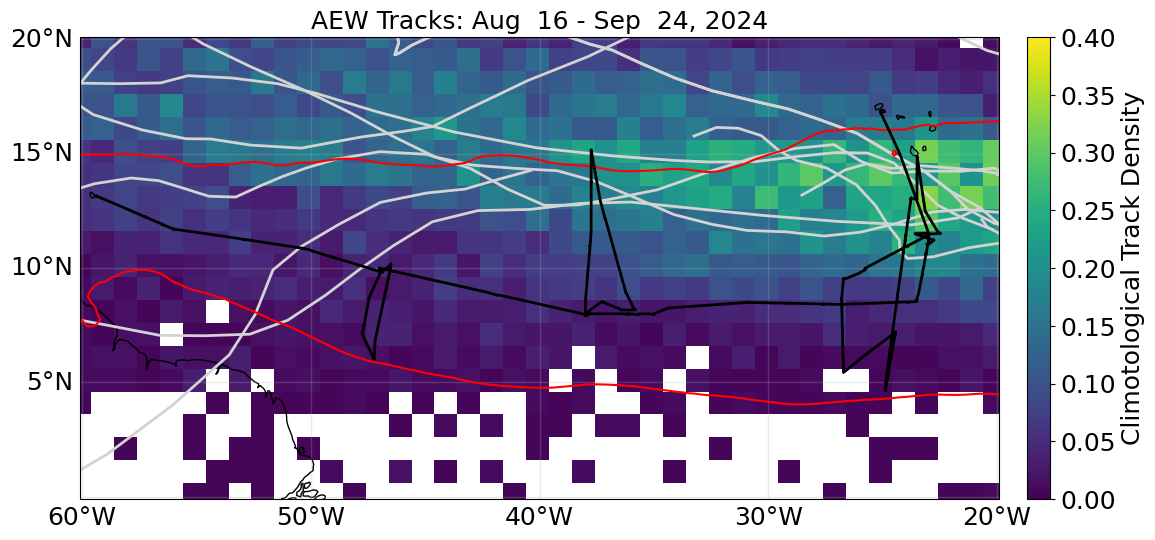

In [15]:
plt.figure(figsize = (18, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution = '50m',linewidth=1,alpha=1)
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

#plot the track density
#cax = ax.imshow(trden_avg, extent=(Xp[0], Xp[-1], Yp[0], Yp[-1]), aspect='auto', cmap='turbo', origin='lower', vmin=0, vmax=0.4)
plt.pcolormesh(Xp, Yp, trden_avg, vmin=0, vmax=0.4)

# Add colorbar
cbar=plt.colorbar(orientation='vertical', pad=0.02)
cbar.set_label('Climotological Track Density',fontsize=18)  #add a label to the colorbar

#plot the AEW tracks in 2024
nAEW2024, ntimeAEW2024 = AEWlat2024.shape
for i in range(nAEW2024):
    ax.plot(AEWlon2024[i, :], AEWlat2024[i, :], 'lightgray', linewidth=2)

##plot mean CWV 48 mm contour from era5
plt.contour(era5.longitude.values,era5.latitude.values, tcwv_mean,levels = [48],colors = 'r',linewidth = 1)

#plot the ship track
ax.plot(shipLON, shipLAT, 'k', linewidth=2)

#Set the plot limits and title
cbar.ax.tick_params(labelsize=18)
ax.set_xlim(lon1, lon2)
ax.set_ylim(lat1, lat2)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'AEW Tracks: Aug  {day1:2.0f} - Sep  {day2:2.0f}, 2024', fontsize=18)   